In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv

In [2]:
# Set the style for seaborn plots
sns.set(style='whitegrid')

def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

In [3]:
def w_msr(sigma, mu):
    # Calculate the weights using the inverse of the covariance matrix
    w = inverse(sigma).dot(mu)
    
    # Ensure non-negative weights
    w = np.maximum(w, 0)
    
    # Scale weights to sum to 1
    w = w / np.sum(w)
    
    return w

In [4]:
def min_cov(sigma, one):
    # Calculate the weights using the inverse of the covariance matrix
    w = inverse(sigma).dot(one)
    
    # Ensure non-negative weights
    w = np.maximum(w, 0)
    
    # Scale weights to sum to 1
    w = w / np.sum(w)
    
    return w

In [5]:
# Define the list of stocks and time period
stocks = ['RELIANCE.BO', 'TCS.BO', 'HDFCBANK.BO', 'BHARTIARTL.BO', 'MARUTI.BO']
start_date = '2019-07-01'
end_date = '2023-07-01'

In [6]:
# Fetch historical data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate expected returns and covariance matrix
mu = returns.mean()
sigma = returns.cov()

# Define the 'one' Series with size 5 and value 1
one = pd.Series(np.ones(len(stocks)), index=stocks)

[*********************100%%**********************]  5 of 5 completed


In [7]:
# Monte Carlo simulation parameters
num_portfolios = 10000
results = np.zeros((num_portfolios, 3))  # Columns for returns, volatility, and Sharpe ratio

# Generate random portfolios
np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    results[i, 0] = portfolio_return
    results[i, 1] = portfolio_volatility
    results[i, 2] = sharpe_ratio

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe Ratio'])


In [8]:
# Optimal portfolios
optimal_weights_max_sharpe = w_msr(sigma, mu)
optimal_weights_min_volatility = min_cov(sigma, one)

# Calculate metrics for the optimal portfolios
max_sharpe_return = np.dot(optimal_weights_max_sharpe, mu)
max_sharpe_volatility = np.sqrt(np.dot(optimal_weights_max_sharpe.T, np.dot(sigma, optimal_weights_max_sharpe)))

min_volatility_return = np.dot(optimal_weights_min_volatility, mu)
min_volatility_volatility = np.sqrt(np.dot(optimal_weights_min_volatility.T, np.dot(sigma, optimal_weights_min_volatility)))

# Print optimal portfolios information
print("Maximum Sharpe Ratio Portfolio:")
print(f"  Weights: \n{optimal_weights_max_sharpe}")
print(f"  Return: {max_sharpe_return:.4f}")
print(f"  Volatility: {max_sharpe_volatility:.4f}")

print("\nMinimum Variance Portfolio:")
print(f"  Weights: \n{optimal_weights_min_volatility}")
print(f"  Return: {min_volatility_return:.4f}")
print(f"  Volatility: {min_volatility_volatility:.4f}")


Maximum Sharpe Ratio Portfolio:
  Weights: 
Ticker
BHARTIARTL.BO    0.466150
HDFCBANK.BO      0.000000
MARUTI.BO        0.034581
RELIANCE.BO      0.283518
TCS.BO           0.215750
dtype: float64
  Return: 0.0010
  Volatility: 0.0146

Minimum Variance Portfolio:
  Weights: 
Ticker
BHARTIARTL.BO    0.184344
HDFCBANK.BO      0.217896
MARUTI.BO        0.093253
RELIANCE.BO      0.098877
TCS.BO           0.405629
dtype: float64
  Return: 0.0007
  Volatility: 0.0130


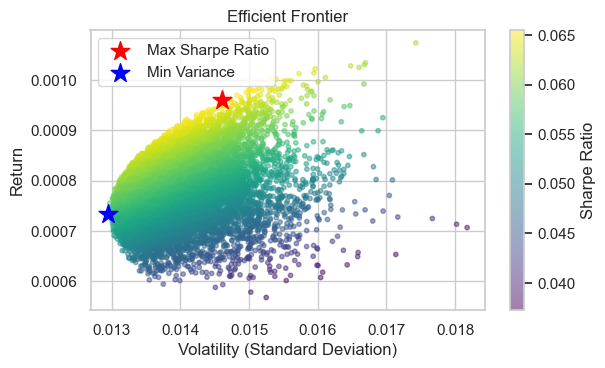

In [9]:
# Plot the Efficient Frontier
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, color='red', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(min_volatility_volatility, min_volatility_return, color='blue', marker='*', s=200, label='Min Variance')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'Max Sharpe Ratio Portfolio Allocation')

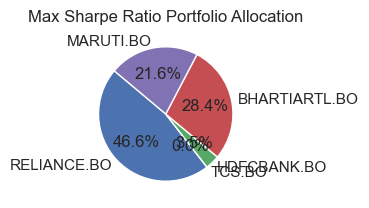

In [10]:
# Plot Pie Chart for Maximum Sharpe Ratio Portfolio
plt.subplot(2, 2, 2)
plt.pie(optimal_weights_max_sharpe, labels=stocks, autopct='%1.1f%%', startangle=140)
plt.title('Max Sharpe Ratio Portfolio Allocation')

Text(0.5, 1.0, 'Min Variance Portfolio Allocation')

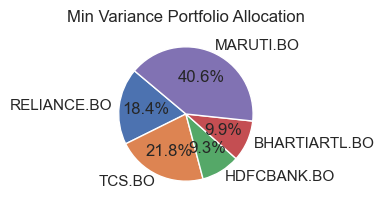

In [11]:
# Plot Pie Chart for Minimum Variance Portfolio
plt.subplot(2, 2, 3)
plt.pie(optimal_weights_min_volatility, labels=stocks, autopct='%1.1f%%', startangle=140)
plt.title('Min Variance Portfolio Allocation')

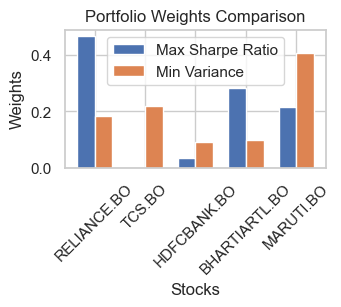

In [12]:
# Plot Comparison Bar Plot
plt.subplot(2, 2, 4)
bar_width = 0.35
index = np.arange(len(stocks))
bar1 = plt.bar(index, optimal_weights_max_sharpe, bar_width, label='Max Sharpe Ratio')
bar2 = plt.bar(index + bar_width, optimal_weights_min_volatility, bar_width, label='Min Variance')

plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.title('Portfolio Weights Comparison')
plt.xticks(index + bar_width / 2, stocks, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()